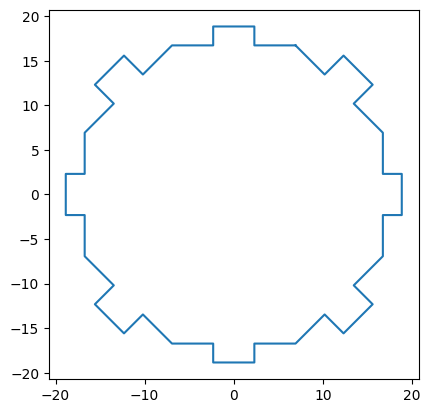

In [1]:
import globals
from plotting import plot_octagon
import matplotlib as mpl
import numpy as np
import matplotlib.pyplot as plt


In [3]:
def plot_trajectory(trials_list, trial_index=0, cmap_winner=mpl.cm.spring, cmap_loser=mpl.cm.summer,
                   s=0.5, social=False, trial=None):
    
    # isolate trial
    if not trial is None:
        this_trial = trial
    else:
        this_trial = trials_list[trial_index]

    # isolate trigger event and activating client
    trigger_event = this_trial[this_trial['eventDescription'] == globals.SELECTED_TRIGGER_ACTIVATION]
    trigger_activating_client = trigger_event['data.triggerClient'].values[0]
    
    # find index of trigger event normalised to this trial
    trigger_idx = trigger_event.index[0]
    trigger_idx = int(trigger_idx - this_trial.index[0])

    # set index for number of players to extract data for 
    end_idx = 1
    if social:
        end_idx = 3
        
    # extract position data for 1 or 2 players
    coordinate_array_labels = [globals.PLAYER_0_XLOC, globals.PLAYER_0_YLOC, globals.PLAYER_1_XLOC, globals.PLAYER_1_YLOC]
    coordinate_arrays = {label : this_trial[label].values[:trigger_idx] for label in coordinate_array_labels[0:end_idx+1]}
    
    # create colormap data
    cmap_winner = mpl.cm.spring 
    cmap_loser = mpl.cm.summer
    timestamps = np.arange(len(coordinate_arrays[globals.PLAYER_0_XLOC]))
    min_val, max_val = min(timestamps), max(timestamps)
    norm = mpl.colors.Normalize(vmin=min_val, vmax=max_val)

    # plot trajectory data
    ax = plot_octagon.plot_octagon()

    if social:
        if trigger_activating_client == 0:
            cmaps = [cmap_winner, cmap_loser]
        else:
            cmaps = [cmap_loser, cmap_winner]
        ax.scatter(coordinate_arrays[globals.PLAYER_0_XLOC], coordinate_arrays[globals.PLAYER_0_YLOC], s=0.5, c=timestamps, cmap=cmaps[0], norm=norm)
        ax.scatter(coordinate_arrays[globals.PLAYER_1_XLOC],coordinate_arrays[globals.PLAYER_1_YLOC], s=0.5, c=timestamps, cmap=cmaps[1], norm=norm)
        plt.show()
    else:
        ax.scatter(coordinate_arrays[globals.PLAYER_0_XLOC], coordinate_arrays[globals.PLAYER_0_YLOC], s=0.5, c=timestamps, cmap=cmap_winner, norm=norm)
        plt.show()
    
    